In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics  
from matplotlib.ticker import MaxNLocator
import pandas as pd
import jieba

In [2]:
#判断是不是中文
def is_Chinese(line_content):
    num = 0
    for ch in line_content:
        if '\u4e00' <= ch <='\u9fff':
            num += 1
    return num

In [3]:
func_word = ['之','其','或','亦','方','于','即','皆','因','仍','故','尚',
      '乃','呀','吗','咧','罢咧','啊','罢','罢了','么','呢','了',
      '的','着','一','不','把','让','向','往','是','在','别','好',
      '可','便','就','但','越','再','更','比','很','偏','儿']

In [6]:
#数据读入
file = open('05.《红楼梦》完整版.txt',encoding='utf-8')
file_context = file.readlines()

hui = 0
hui_start_num = []
#不是仅仅是针对中文, 可以针对任何的字符串，u代表是对字符串进行unicode编码。  所以一般不带u；但是中文, 必须表明所需编码, 否则一旦编码转换就会出现乱码。 

for i in range(0,len(file_context)):
    round = re.findall(u'第[一二三四五六七八九十百]+回',file_context[i])
    if(len(round) == 1) & (file_context[i][0] == '第') & (len(file_context[i]) < 30):
        hui_start_num.append(i)
        hui += 1
hui_start_num.append(len(file_context))

In [148]:
# hui_start_num 存储行号

In [7]:
frequency = [[0]*len(func_word) for _ in range(hui)]
#建立一个矩阵列表，120个一维46个0

frequency_rate = [[0]*len(func_word) for _ in range(hui)]

In [8]:
#回，行，虚词
for i in range(0,hui):
    all_character_num = 0 #
    for j in range(hui_start_num[i]+1,hui_start_num[i+1]):
        # print(i)
        # row_contxt = np.array(file_context[j])
        row_contxt = jieba.lcut(file_context[j])
        num = (is_Chinese(row_contxt))#判断这一行对应位置是否是汉字
        # print(bool_row_context)
        all_character_num += num
        # print(all_character_num)
        for k in range(0,len(func_word)):
            frequency[i][k] += len(re.findall(func_word[k],file_context[j]))#每一回每一个虚词出现的次数，遍历这一回的所有行，进行统计
    frequency[i][18] -= frequency[i][16] + frequency[i][19]
    
    for j in range(0,len(func_word)):
#         print('虚词{} {}个,汉字总个数{}个'.format(func_word[j],frequency[i][j],all_character_num))
        
        frequency_rate[i][j] = frequency[i][j]*100 / all_character_num
        #计算每一回中每个虚词占所有汉字的比例


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\王浩\AppData\Local\Temp\jieba.cache
Loading model cost 0.678 seconds.
Prefix dict has been built successfully.


### k-means

In [10]:
from sklearn.cluster import KMeans

Text(0, 0.5, 'davies_bouldin_score')

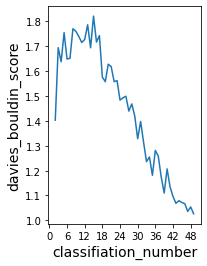

In [11]:
classified_num = 50
preds = []
#根据虚词出现的频率划分

for i in np.arange(2,classified_num):
    y_pred = KMeans(n_clusters=i,random_state=9).fit_predict(frequency_rate)
    #y_pred 返回的是对每一回的预测分类
    preds.append(metrics.davies_bouldin_score(frequency_rate,y_pred))
    #浮点数 戴维森堡丁指数(DBI) # DBI的值最小是0，值越小，代表聚类效果越好。
plt.subplot(121)
# print(len(preds))
plt.plot(np.arange(2,classified_num),preds)#画某一个分类数量之下的预测值
plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True))
plt.xlabel('classifiation_number',fontsize = 14)
plt.ylabel('davies_bouldin_score',fontsize = 14)


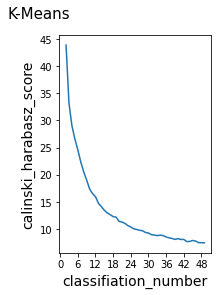

In [12]:
#绘制CH得分虚线
preds = []
for i in np.arange(2,classified_num):
    y_pred = KMeans(n_clusters=i,random_state=9).fit_predict(frequency_rate)
    preds.append(metrics.calinski_harabasz_score(frequency_rate,y_pred))
plt.subplot(122)
plt.plot(np.arange(2,classified_num),preds)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True))
plt.xlabel('classifiation_number',fontsize = 14)
plt.ylabel('calinski_harabasz_score',fontsize = 14)
plt.suptitle('K-Means',fontsize = 15)
# plt.subtitle('K-Means',fontsize = 15)
plt.show()

### 层次聚类

In [13]:
from sklearn import cluster

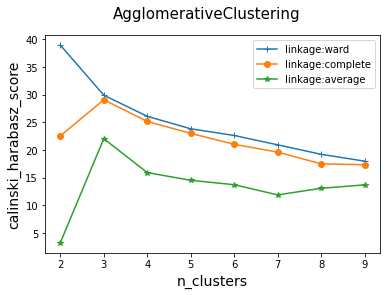

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
markers = "+o*"

linkages = ['ward','complete','average']#不同的损失函数
classified_num = 10
nums = range(2,classified_num)

for i,linkage in enumerate(linkages):
    preds = []
    for num in nums:
        clst = cluster.AgglomerativeClustering(n_clusters = num,linkage = linkage)
        predicted_labels = clst.fit_predict(frequency_rate)
        preds.append(metrics.calinski_harabasz_score(frequency_rate,predicted_labels))
    ax.plot(nums,preds,marker = markers[i],label = 'linkage:%s' % linkage)
ax.set_xlabel('n_clusters',fontsize = 14)
ax.set_ylabel('calinski_harabasz_score',fontsize = 14)
ax.legend(loc = 'best')
fig.suptitle('AgglomerativeClustering',fontsize = 15)
plt.show()

In [ ]:
# 观察发现linkage选取ward比较平稳，且二聚类的得分最高，这与K-means的结果类似

### DBSCAN

In [15]:
from sklearn.cluster import DBSCAN

In [40]:
models,scores = [],[]
epsilons = np.linspace(0.5, 6, 10000)

In [17]:
frequency_rate

[[1.9492656875834447,
  0.37383177570093457,
  0.24032042723631508,
  0.3204272363150868,
  0.6408544726301736,
  0.48064085447263016,
  0.1602136181575434,
  0.2136181575433912,
  0.8010680907877169,
  0.0534045393858478,
  0.4272363150867824,
  0.1602136181575434,
  0.4272363150867824,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.18691588785046728,
  0.0534045393858478,
  0.0801068090787717,
  0.0267022696929239,
  2.643524699599466,
  0.6942590120160214,
  0.48064085447263016,
  2.9105473965287048,
  3.2042723631508676,
  0.13351134846461948,
  0.0267022696929239,
  0.0801068090787717,
  0.1068090787716956,
  1.335113484646195,
  0.6141522029372497,
  0.1068090787716956,
  0.6408544726301736,
  0.8811748998664887,
  1.2016021361815754,
  0.24032042723631508,
  0.26702269692923897,
  0.0534045393858478,
  0.4272363150867824,
  0.1068090787716956,
  0.1602136181575434,
  0.0,
  0.0267022696929239,
  0.26702269692923897],
 [2.6606099935107075,
  0.5840363400389358,
  0.06489292667099286,
  0

In [33]:
model = DBSCAN(min_samples = 3)
model.fit(frequency_rate)
    # print(model.labels_)
if np.unique(model.labels_).shape[0]<2:#保证分类数至少为2
            print('#')

#


In [28]:
len(frequency_rate[1])

46

In [23]:
np.unique(model.labels_)

array([-1], dtype=int64)

In [52]:
model = DBSCAN(eps = 1.3,min_samples = 3)
model.fit(frequency_rate)
print(model.labels_)
score = metrics.calinski_harabasz_score(frequency_rate,model.labels_)
print(score)

[-1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  1 -1 -1 -1  0 -1 -1  0  0 -1  0 -1  0
  0  0  0  0  0 -1  0  0 -1  0 -1  0 -1 -1 -1 -1  0  0  0 -1  0 -1  0  0
  0  0 -1  0 -1  0  0 -1  0 -1  0  0 -1  0  0  1  0 -1  0  0  0  0  0 -1
  0  0 -1  1  0 -1  0  0  0  0  0  0 -1 -1  0  0  0 -1 -1  0  0  0 -1  0
  0  0  0  2 -1 -1  0  2 -1 -1  0  0  0 -1  0  0 -1  2  0 -1 -1  0  0 -1]
3.4726863097971457


In [41]:
for eps in epsilons:
    model = DBSCAN(eps = eps,min_samples = 3)
    model.fit(frequency_rate)
    # print(model.labels_)
    if np.unique(model.labels_).shape[0]<2:#保证分类数至少为2
#         print(np.unique(model.labels_))
        continue
#     print('#')
    score = metrics.calinski_harabasz_score(frequency_rate,model.labels_)
    models.append(model)
    scores.append(score)

index = np.array(scores).argmax()
best_model = models[index]
best_eps = epsilons[index]
best_score = scores[index]

predicted_labels = np.unique(best_model.labels_)
print(predicted_labels)
print(best_model.labels_)
print(best_eps)
print(best_score)





[-1  0]
[-1 -1  0  0 -1  0  0  0  0  0 -1  0  0  0  0  0 -1 -1  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1.2172717271727174
14.225415194702496


### 模型分类分类相似度

In [34]:
frequency_rate

[[1.825,
  0.35,
  0.225,
  0.3,
  0.6,
  0.45,
  0.15,
  0.2,
  0.75,
  0.05,
  0.4,
  0.15,
  0.4,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.175,
  0.05,
  0.075,
  0.025,
  2.475,
  0.65,
  0.45,
  2.725,
  3.0,
  0.125,
  0.025,
  0.075,
  0.1,
  1.25,
  0.575,
  0.1,
  0.6,
  0.825,
  1.125,
  0.225,
  0.25,
  0.05,
  0.4,
  0.1,
  0.15,
  0.0,
  0.025,
  0.25],
 [3.28,
  0.72,
  0.08,
  0.4,
  0.6,
  0.48,
  0.16,
  0.4,
  1.24,
  0.08,
  0.36,
  0.08,
  0.32,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.08,
  0.0,
  0.12,
  0.12,
  3.64,
  2.44,
  0.48,
  3.68,
  3.64,
  0.16,
  0.12,
  0.12,
  0.12,
  2.32,
  1.0,
  0.24,
  0.36,
  0.84,
  1.28,
  0.52,
  0.16,
  0.04,
  0.16,
  0.24,
  0.24,
  0.0,
  0.04,
  0.68],
 [2.769230769230769,
  0.5,
  0.11538461538461539,
  0.6153846153846154,
  1.1153846153846154,
  0.38461538461538464,
  0.3076923076923077,
  0.2692307692307692,
  1.0769230769230769,
  0.07692307692307693,
  0.2692307692307692,
  0.11538461538461539,
  0.19230769230769232,


In [44]:
KMeans_predict = KMeans(n_clusters=2,random_state = 9).fit_predict(frequency_rate)
print(KMeans_predict)
AgglomerativeClustering_predict = \
(np.array(cluster.AgglomerativeClustering(n_clusters=2,linkage = 'ward').fit_predict(frequency_rate))==0).astype(int)

print(AgglomerativeClustering_predict)

print('Kmeans聚类与层次分析结果的相似度',np.sum((KMeans_predict == AgglomerativeClustering_predict)==1)/hui)


[0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1
 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1
 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
Kmeans聚类与层次分析结果的相似度 0.9333333333333333


In [9]:
re.findall??

Signature: re.findall(pattern, string, flags=0)
Source:   
def findall(pattern, string, flags=0):
    """Return a list of all non-overlapping matches in the string.

    If one or more capturing groups are present in the pattern, return
    a list of groups; this will be a list of tuples if the pattern
    has more than one group.

    Empty matches are included in the result."""
    return _compile(pattern, flags).findall(string)
File:      d:\download\anaconda\neirong\lib\re.py
Type:      function


In [7]:
file_context=data.readlines()

AttributeError: 'DataFrame' object has no attribute 'readlines'